# Import Required Libraries

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import pandas as pd
from torch.utils.data import Dataset

torch.manual_seed(42)
print(torch.cuda.is_available())

True


# Load the Pre-Processed Data

We use 2022 data as training data and see how well it works on 2023 data.


In [2]:
train_path = "2022_training.csv"
train_df = pd.read_csv(train_path, sep=';')
train_df.head()

,Unnamed: 0,FZ_AB,Besetzung,Tage_DWV,Tage_SA,Tage_SO,Tage_SA_N,Tage_SO_N,Line_2,Line_3,...,Line_753,Line_910,Line_912,Line_916,Line_918,Line_919,GPS_Latitude_From,GPS_Longitude_From,GPS_Latitude_To,GPS_Longitude_To
0,0,21.0,3.22000,True,False,False,False,False,False,False,...,False,False,False,False,False,False,47.394903,8.489476,47.390838,8.488814
1,1,21.5,2.83636,True,False,False,False,False,False,False,...,False,False,False,False,False,False,47.394903,8.489476,47.390838,8.488814
2,2,21.5,3.10417,True,False,False,False,False,False,False,...,False,False,False,False,False,False,47.394903,8.489476,47.390838,8.488814
3,3,22.0,3.06897,True,False,False,False,False,False,False,...,False,False,False,False,False,False,47.394903,8.489476,47.390838,8.488814
4,4,22.0,2.57143,True,False,False,False,False,False,False,...,False,False,False,False,False,False,47.394903,8.489476,47.390838,8.488814


In [3]:
test_path = "2023_testing.csv"
test_df = pd.read_csv(test_path, sep=';')
test_df.head()

,Unnamed: 0,FZ_AB,Besetzung,Tage_DWV,Tage_SA,Tage_SO,Tage_SA_N,Tage_SO_N,Line_2,Line_3,...,Line_753,Line_910,Line_912,Line_916,Line_918,Line_919,GPS_Latitude_From,GPS_Longitude_From,GPS_Latitude_To,GPS_Longitude_To
0,0,9.5,0.44444,False,False,True,False,False,False,False,...,False,False,False,False,False,False,47.397778,8.54175,47.400252,8.54347
1,1,10.0,1.60000,False,False,True,False,False,False,False,...,False,False,False,False,False,False,47.397778,8.54175,47.400252,8.54347
2,2,11.5,35.98734,True,False,False,False,False,False,False,...,False,False,False,False,False,False,47.397778,8.54175,47.400252,8.54347
3,3,11.5,35.13333,True,False,False,False,False,False,False,...,False,False,False,False,False,False,47.397778,8.54175,47.400252,8.54347
4,4,11.5,35.15909,True,False,False,False,False,False,False,...,False,False,False,False,False,False,47.397778,8.54175,47.400252,8.54347


# Clean and Normalize Data

We drop nan values (these occur at the first drive of a day when there is not yet a "From" value) and normalize the data.
We normalize based on training statistics and save them for later use (to undo normalization).

In [4]:
train_df.isna().any()

Unnamed: 0            False
FZ_AB                 False
Besetzung             False
Tage_DWV              False
Tage_SA               False
                      ...  
Line_919              False
GPS_Latitude_From      True
GPS_Longitude_From     True
GPS_Latitude_To        True
GPS_Longitude_To       True
Length: 119, dtype: bool

In [5]:
# We calculate all statistics on the training set!
train_df = train_df.dropna() # some buses are starting a tour and have nan values for "From columns"
test_df = test_df.dropna()

# remove lines that changed between the years
train_df = train_df.drop(['Unnamed: 0', 'Line_303', 'Line_308', 'Line_311', 'Line_331'], axis=1)
test_df = test_df.drop(['Unnamed: 0', 'Line_332', ], axis=1)

gps_latitude_mean = 0.5* (train_df['GPS_Latitude_From'].mean() + train_df['GPS_Latitude_To'].mean())
gps_latitude_std = 0.5* (train_df['GPS_Latitude_From'].std() + train_df['GPS_Latitude_To'].std())
gps_longitude_mean = 0.5* (train_df['GPS_Longitude_From'].mean() + train_df['GPS_Longitude_To'].mean())
gps_longitude_std = 0.5* (train_df['GPS_Longitude_From'].mean() + train_df['GPS_Longitude_To'].mean())
target_mean = train_df['Besetzung'].mean()
target_std = train_df['Besetzung'].std()

def preprocess_data(df):
    df['GPS_Latitude_From'] = (df['GPS_Latitude_From'] - gps_latitude_mean) / gps_latitude_std
    df['GPS_Latitude_To'] = (df['GPS_Latitude_To'] - gps_latitude_mean) / gps_latitude_std
    df['GPS_Longitude_From'] = (df['GPS_Longitude_From'] - gps_longitude_mean) / gps_longitude_std
    df['GPS_Longitude_To'] = (df['GPS_Longitude_To'] - gps_longitude_mean) / gps_longitude_std
    df['Besetzung'] = (df['Besetzung'] - target_mean) / target_std
    
    return df

train_df = preprocess_data(train_df)
test_df = preprocess_data(test_df)


# Define Torch Dataset and DataLoader

In [6]:
class VbzDataset(Dataset):
    
    def __init__(self, df):
        self.target = torch.Tensor(df['Besetzung'].values).unsqueeze(1)
        self.data = torch.tensor(df.drop(['Besetzung'], axis=1).values.astype(np.float32))
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        return self.data[idx], self.target[idx]

batch_size = 512

train_dataset = VbzDataset(train_df)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True)

test_set = VbzDataset(test_df)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, shuffle=False, pin_memory=True)

# Define Model

The model consists of multiple blocks of linear layers with batch normalization and dropout. The model is configurable and dynamically blocks of different sizes can be added.

In [7]:
class ModelBlock(nn.Module):
    def __init__(self, in_features, out_features):
        super(ModelBlock, self).__init__()
        self.fc = nn.Linear(in_features, out_features)
        self.bn = nn.BatchNorm1d(out_features)
        self.dropout = nn.Dropout(0.2)
        
    def forward(self, x):
        x = self.dropout(F.relu(self.bn(self.fc(x))))
        return x

class VbzModel(nn.Module):
    def __init__(self, feature_dimensions):
        super(VbzModel, self).__init__()
        
        self.blocks = nn.ModuleList([ModelBlock(feature_dimensions[i], feature_dimensions[i+1]) for i in range(len(feature_dimensions) - 1)])
        self.blocks = nn.Sequential(*self.blocks)
        self.fc_out = nn.Linear(feature_dimensions[-1], 1)
        
    def forward(self, x):
        z = self.blocks(x)
        y = self.fc_out(z)
        return y

# Define the Model, Loss, Optimizer and Learning Rate Scheduler

We use the Adam optimizer and the Mean Squared Error loss. We also use a learning rate scheduler to reduce the learning rate if the loss does not improve for a certain number of epochs.


In [11]:
model = VbzModel([113, 512, 512, 756, 756])
loss = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)
lr_scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3)

epochs = 100
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Helper Function to Calculate Statistics During Training and Testing

We calculate the Mean Absolute Error and the Mean Squared Error. We also undo the normalization to get the actual values.

In [12]:
def calculate_statistics(output, target):
    output = output * target_std + target_mean
    target = target * target_std + target_mean
    
    return F.l1_loss(output, target, reduction="sum"), F.mse_loss(output, target, reduction="sum")

# Train the Model

We iterate between running training and testing epochs. We save the model with the best Mean Absolute Error on the test set.

In [13]:
model.to(device)

best_mae = 100
train_loss_epochs, test_loss_epochs = [], []
train_mae_epochs, test_mae_epochs = [], []
train_mse_epochs, test_mse_epochs = [], []
for epoch in range(epochs):
    loss_sum, mae_sum, mse_sum = 0, 0, 0
    model.train()
    for i, data in enumerate(train_loader):
        inputs, targets = data
        inputs, targets = inputs.to(device), targets.to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss_val = loss(outputs, targets)
        loss_val.backward()
        # torch.nn.utils.clip_grad_norm_(model.parameters(), 0.1)
        optimizer.step()
        
        loss_sum += loss_val.item() * inputs.size(0)
        mae, mse = calculate_statistics(outputs, targets)
        mae_sum += mae.item()
        mse_sum += mse.item()
        
    train_loss_epochs.append(loss_sum / len(train_loader.dataset))
    train_mae_epochs.append(mae_sum / len(train_loader.dataset))
    train_mse_epochs.append(mse_sum / len(train_loader.dataset))
    print(f'Training: Epoch: {epoch+1}, Loss: {train_loss_epochs[-1]}, MAE: {train_mae_epochs[-1]}, MSE: {train_mse_epochs[-1]}')
    
    loss_sum, mae_sum, mse_sum = 0, 0, 0
    model.eval()
    with torch.no_grad():
        for i, data in enumerate(test_loader):
            inputs, targets = data
            inputs, targets = inputs.to(device), targets.to(device)
            
            outputs = model(inputs)
            loss_val = loss(outputs, targets)
            loss_sum += loss_val.item() * inputs.size(0)
            mae, mse = calculate_statistics(outputs, targets)
            mae_sum += mae.item()
            mse_sum += mse.item()
    
    test_loss_epochs.append(loss_sum / len(test_loader.dataset))
    test_mae_epochs.append(mae_sum / len(test_loader.dataset))
    test_mse_epochs.append(mse_sum / len(test_loader.dataset))
    print(f'Testing: Epoch: {epoch+1}, Loss: {test_loss_epochs[-1]}, MAE: {test_mae_epochs[-1]}, MSE: {test_mse_epochs[-1]}')

    if test_mae_epochs[-1] < best_mae:
        torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': loss,
            }, "checkpoint.pth")
        best_mae = test_mae_epochs[-1]

    lr_scheduler.step(test_loss_epochs[-1])

Training: Epoch: 1, Loss: 0.401639325364841, MAE: 6.904274487360498, MSE: 102.27585657411788
Testing: Epoch: 1, Loss: 0.5044501053602732, MAE: 7.647179876539144, MSE: 128.4562144658258
Training: Epoch: 2, Loss: 0.29382743164026276, MAE: 6.000070918497261, MSE: 74.82198710310489
Testing: Epoch: 2, Loss: 0.4251454263312212, MAE: 6.8041595520884846, MSE: 108.26159268760476
Training: Epoch: 3, Loss: 0.27444295526975976, MAE: 5.782654278640321, MSE: 69.88580717352005
Testing: Epoch: 3, Loss: 0.3809397213515582, MAE: 6.489043972868728, MSE: 97.00478534010597
Training: Epoch: 4, Loss: 0.2625761896238666, MAE: 5.641010553744997, MSE: 66.86398255040183
Testing: Epoch: 4, Loss: 0.3437351549445908, MAE: 6.17230894000698, MSE: 87.5307906033232
Training: Epoch: 5, Loss: 0.25207880130024923, MAE: 5.513610295114524, MSE: 64.19086420531261
Testing: Epoch: 5, Loss: 0.4562618108308863, MAE: 7.235005560008501, MSE: 116.18525680933638
Training: Epoch: 6, Loss: 0.2457304889005808, MAE: 5.436343072329594, M

# Plot Training and Testing Metrics

In [56]:
import matplotlib.pyplot as plt

def plot_metric(train, test, metric, title, save_path=None):
    plt.figure(dpi=300)
    plt.plot(train, label=f'Train {metric}')
    plt.plot(test, label=f'Test {metric}')
    plt.title(title)
    plt.xlabel('Epoch')
    plt.ylabel(metric)
    plt.grid()
    plt.tight_layout()
    plt.legend()
    if save_path is not None:
        plt.savefig(save_path)
    plt.show()

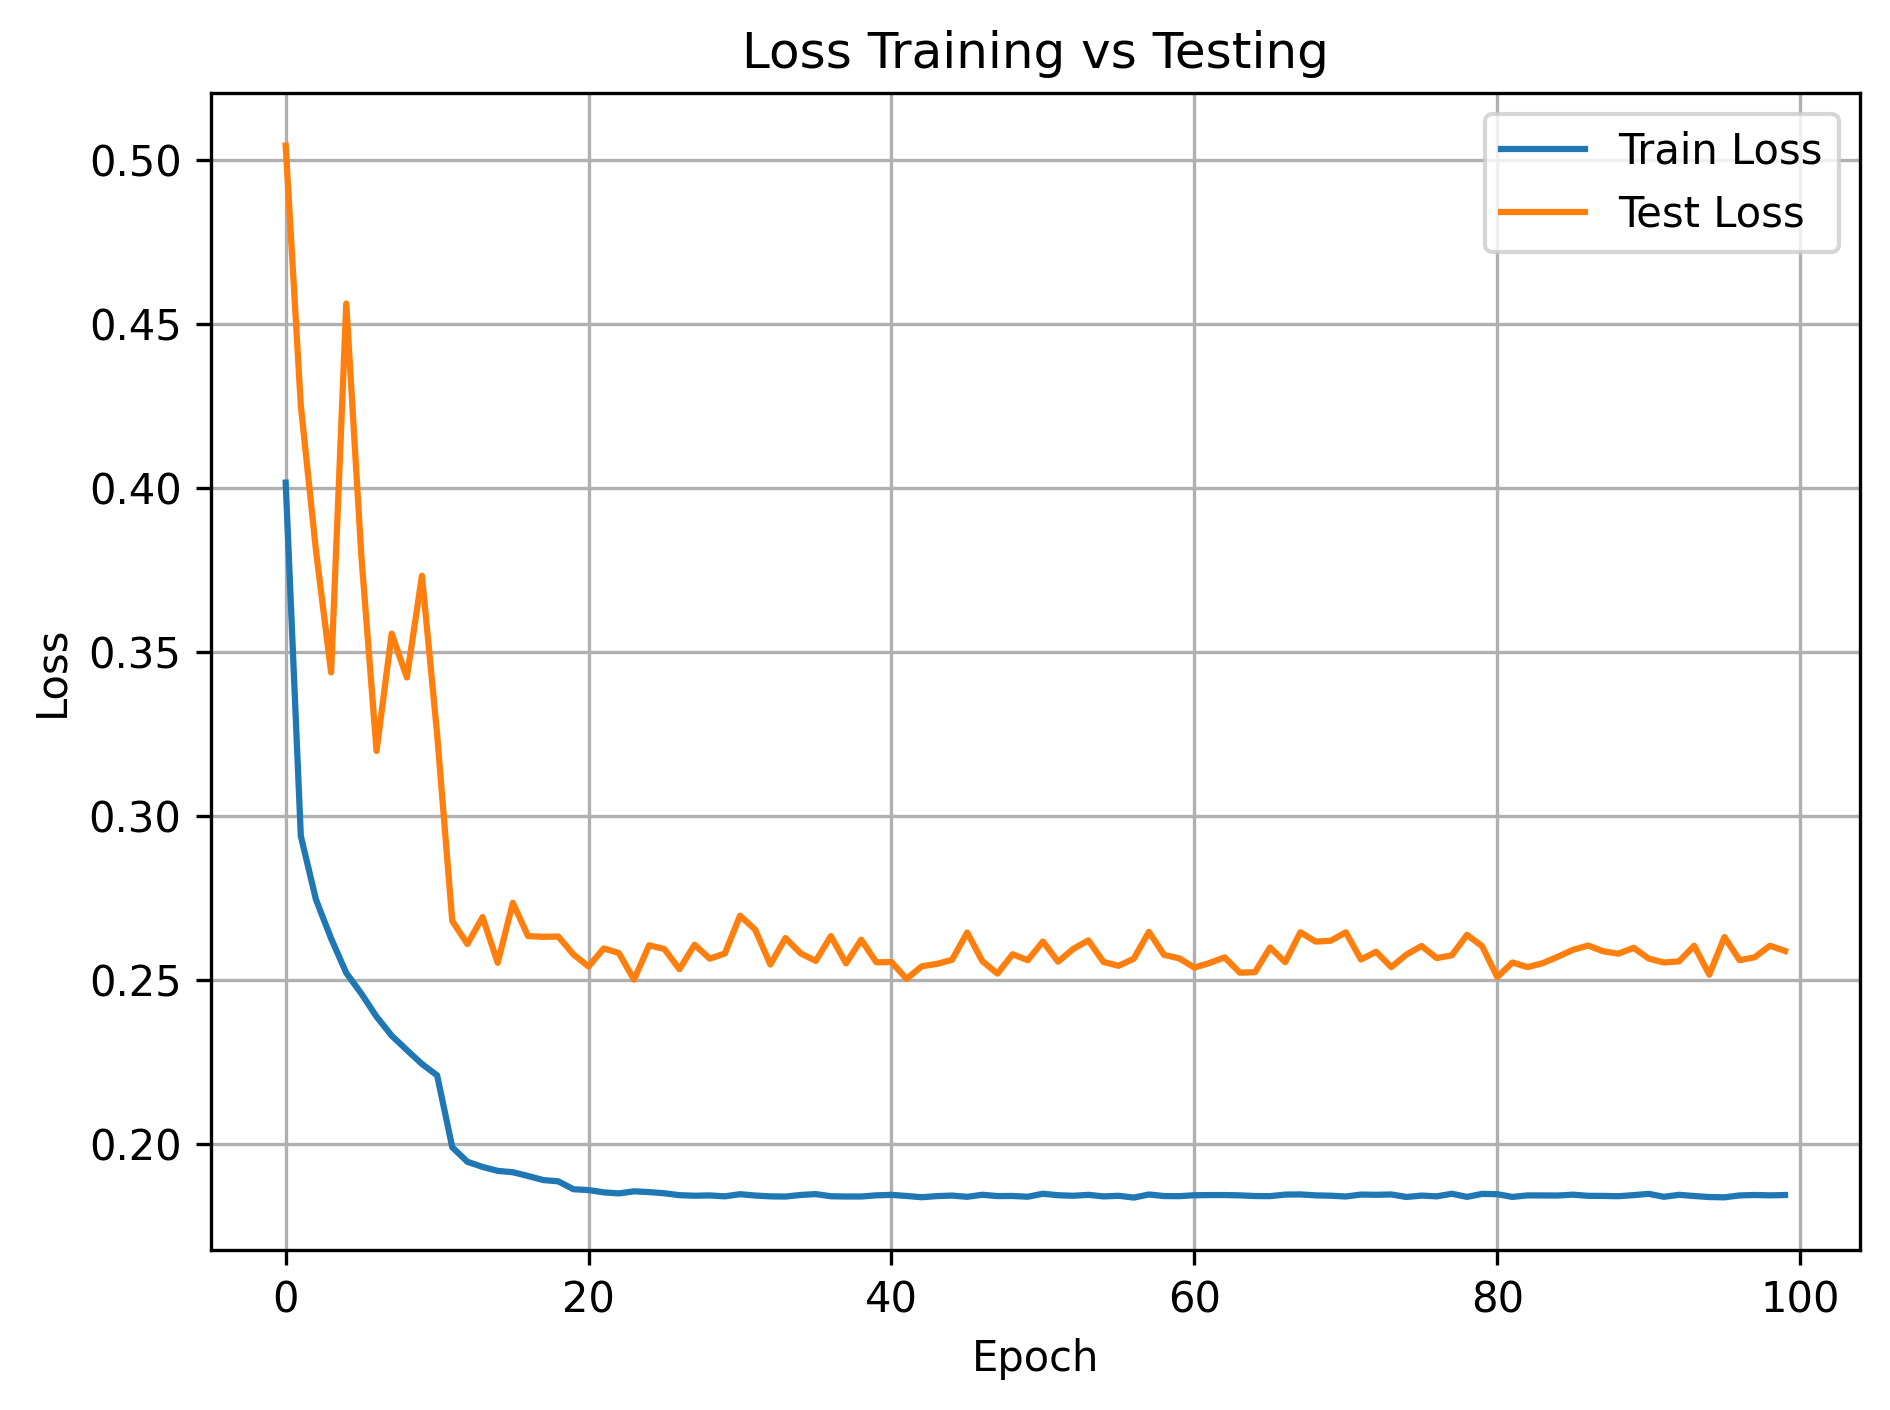

In [57]:
plot_metric(train_loss_epochs, test_loss_epochs, 'Loss', 'Loss Training vs Testing', 'loss_over_epochs.png')

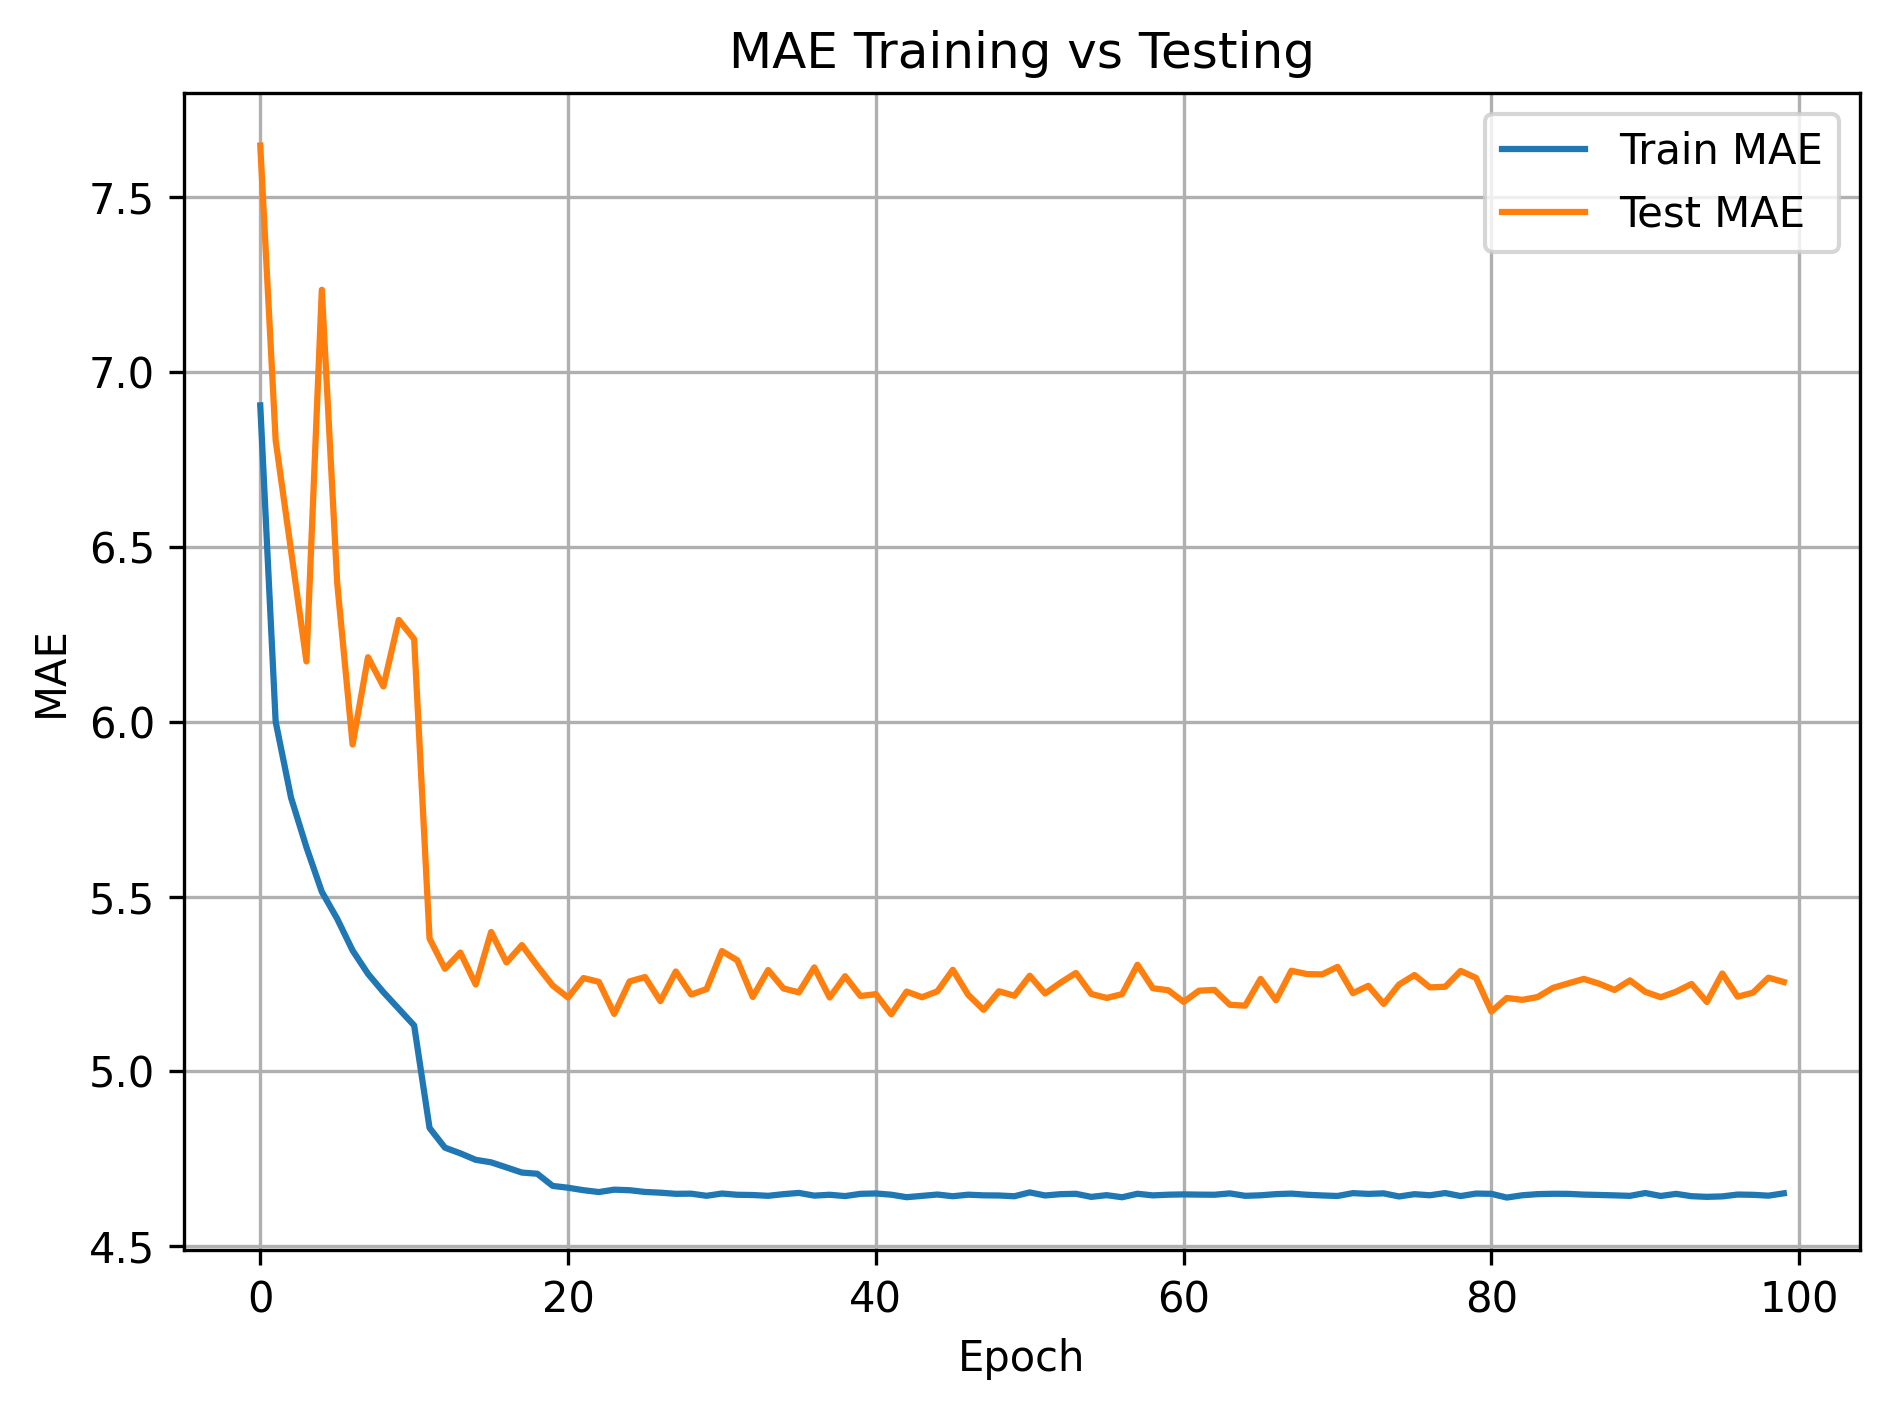

In [58]:
plot_metric(train_mae_epochs, test_mae_epochs, 'MAE', 'MAE Training vs Testing', 'mae_over_epochs.png')

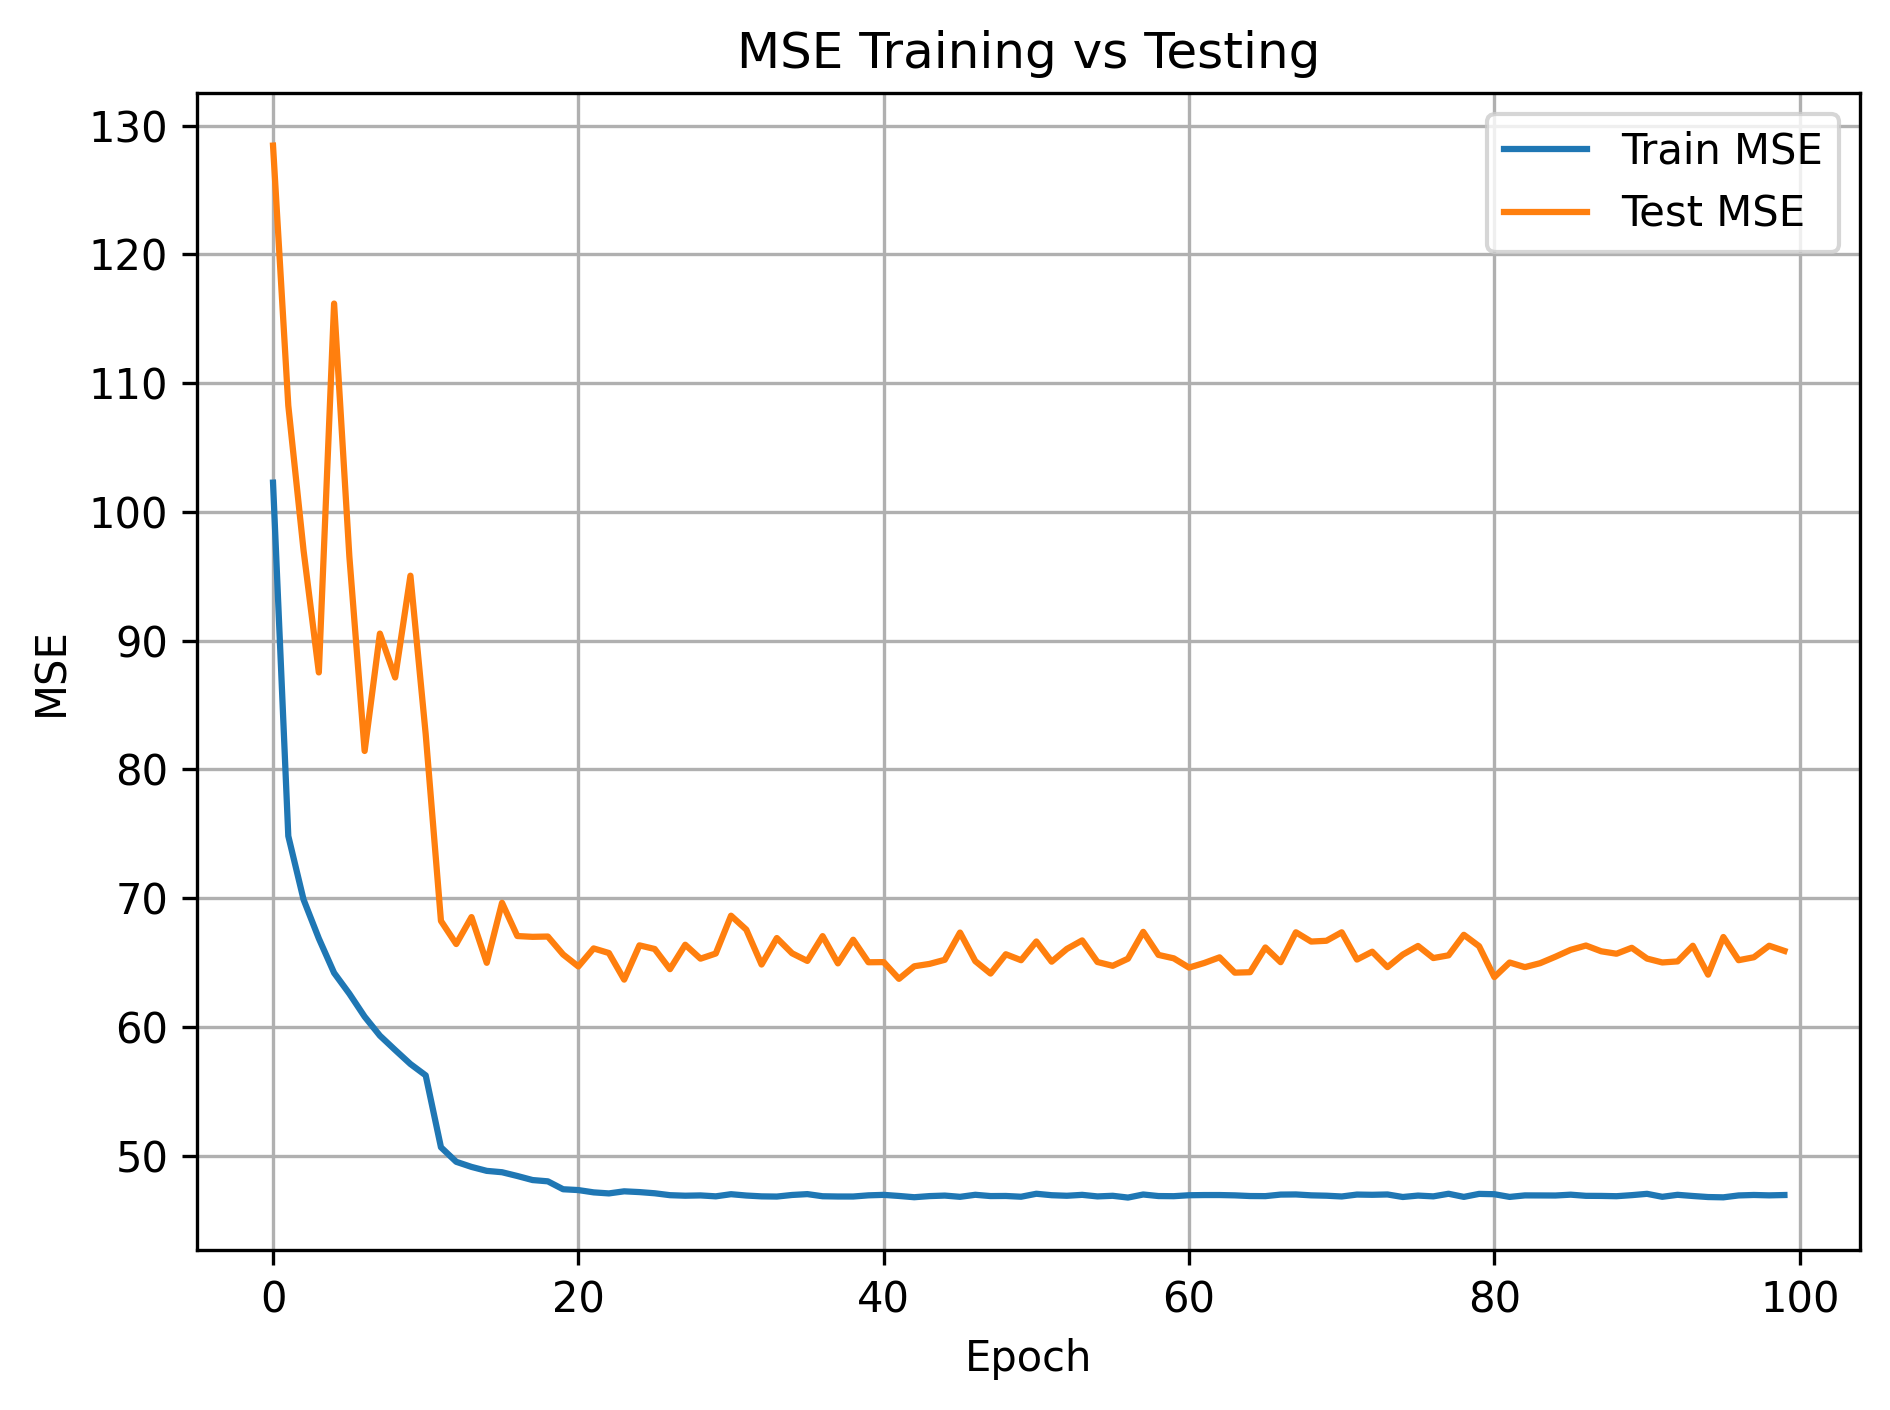

In [59]:
plot_metric(train_mse_epochs, test_mse_epochs, 'MSE', 'MSE Training vs Testing', 'mse_over_epochs.png')

# Load the Best Model and Evaluate on the Test Set

In [19]:
best_model = VbzModel([113, 512, 512, 756, 756])
best_model.load_state_dict(torch.load("checkpoint.pth")["model_state_dict"])

best_model.to(device)

VbzModel(
  (blocks): Sequential(
    (0): ModelBlock(
      (fc): Linear(in_features=113, out_features=512, bias=True)
      (bn): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (dropout): Dropout(p=0.2, inplace=False)
    )
    (1): ModelBlock(
      (fc): Linear(in_features=512, out_features=512, bias=True)
      (bn): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (dropout): Dropout(p=0.2, inplace=False)
    )
    (2): ModelBlock(
      (fc): Linear(in_features=512, out_features=756, bias=True)
      (bn): BatchNorm1d(756, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (dropout): Dropout(p=0.2, inplace=False)
    )
    (3): ModelBlock(
      (fc): Linear(in_features=756, out_features=756, bias=True)
      (bn): BatchNorm1d(756, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (dropout): Dropout(p=0.2, inplace=False)
    )
  )
  (fc_out): Linear(in_features=756

In [20]:
def evaluate_model(model, loader):
    model.eval()
    loss_sum, mae_sum, mse_sum = 0, 0, 0
    all_inputs, all_predictions, all_targets = [], [], []
    with torch.no_grad():
        for i, data in enumerate(loader):
            inputs, targets = data
            inputs, targets = inputs.to(device), targets.to(device)
            
            outputs = model(inputs)
            loss_val = loss(outputs, targets)
            loss_sum += loss_val.item() * inputs.size(0)
            mae, mse = calculate_statistics(outputs, targets)
            mae_sum += mae.item()
            mse_sum += mse.item()
            
            all_inputs.extend([inputs[i] for i in range(inputs.size(0))])
            all_predictions.extend([outputs[i] for i in range(outputs.size(0))])
            all_targets.extend([targets[i] for i in range(targets.size(0))])
    
    return loss_sum / len(loader.dataset), mae_sum / len(loader.dataset), mse_sum / len(loader.dataset), all_inputs, all_predictions, all_targets

# Calculate the Test Metrics

We calculate the Mean Absolute Error and the Mean Squared Error on the test set.
The results are decent, we are "only" 5 passengers off on average.
We consider this quite good, given that we trained on 2022 data and tested on 2023 data and these datasets have quite different statistics (see other notebooks).

In [21]:
test_loss, test_mae, test_mse, all_inputs, all_predictions, all_targets = evaluate_model(best_model, test_loader)
print(f'Test Loss: {test_loss}, Test MAE: {test_mae}, Test MSE: {test_mse}')

Test Loss: 0.2502602381060688, Test MAE: 5.163217640989322, Test MSE: 63.727774871068654


# Create Result DataFrame

We create a DataFrame with the inputs, predictions, and targets to analyze the results.
This allows simpler analytics / plots as we can use pandas and seaborn.

In [23]:
results_df = pd.DataFrame({
    'Input': [input.cpu().numpy() for input in all_inputs],
})
results_df = pd.DataFrame(results_df['Input'].to_list(), columns=train_df.drop(['Besetzung'], axis=1).columns)
results_df['Prediction'] = [prediction.item() for prediction in all_predictions]
results_df['Target'] = [target.item() for target in all_targets]

results_df.head()

,FZ_AB,Tage_DWV,Tage_SA,Tage_SO,Tage_SA_N,Tage_SO_N,Line_2,Line_3,Line_4,Line_5,...,Line_912,Line_916,Line_918,Line_919,GPS_Latitude_From,GPS_Longitude_From,GPS_Latitude_To,GPS_Longitude_To,Prediction,Target
0,9.5,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.592357,0.001683,0.6973,0.001884,-1.070626,-1.197121
1,10.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.592357,0.001683,0.6973,0.001884,-1.056321,-1.124707
2,11.5,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.592357,0.001683,0.6973,0.001884,0.841955,1.030208
3,11.5,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.592357,0.001683,0.6973,0.001884,0.841955,0.976690
4,11.5,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.592357,0.001683,0.6973,0.001884,0.841955,0.978305


In [24]:
# undo the normalization
results_df['Prediction'] = results_df['Prediction'] * target_std + target_mean
results_df['Target'] = results_df['Target'] * target_std + target_mean
results_df['GPS_Latitude_From'] = results_df['GPS_Latitude_From'] * gps_latitude_std + gps_latitude_mean
results_df['GPS_Latitude_To'] = results_df['GPS_Latitude_To'] * gps_latitude_std + gps_latitude_mean
results_df['GPS_Longitude_From'] = results_df['GPS_Longitude_From'] * gps_longitude_std + gps_longitude_mean
results_df['GPS_Longitude_To'] = results_df['GPS_Longitude_To'] * gps_longitude_std + gps_longitude_mean

# calculate the absolute error
results_df['absolute error'] = abs(results_df['Prediction'] - results_df['Target'])

results_df.head()

,FZ_AB,Tage_DWV,Tage_SA,Tage_SO,Tage_SA_N,Tage_SO_N,Line_2,Line_3,Line_4,Line_5,...,Line_916,Line_918,Line_919,GPS_Latitude_From,GPS_Longitude_From,GPS_Latitude_To,GPS_Longitude_To,Prediction,Target,absolute error
0,9.5,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,47.397778,8.54175,47.400249,8.543469,2.463007,0.444441,2.018566
1,10.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,47.397778,8.54175,47.400249,8.543469,2.691279,1.599999,1.091280
2,11.5,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,47.397778,8.54175,47.400249,8.543469,32.983269,35.987339,3.004070
3,11.5,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,47.397778,8.54175,47.400249,8.543469,32.983269,35.133330,2.150061
4,11.5,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,47.397778,8.54175,47.400249,8.543469,32.983269,35.159090,2.175821


In [25]:
results_df['absolute error'].mean() # -> correct

5.1632175472356865

# Create Plots of the Results

<Figure size 1920x1440 with 0 Axes>

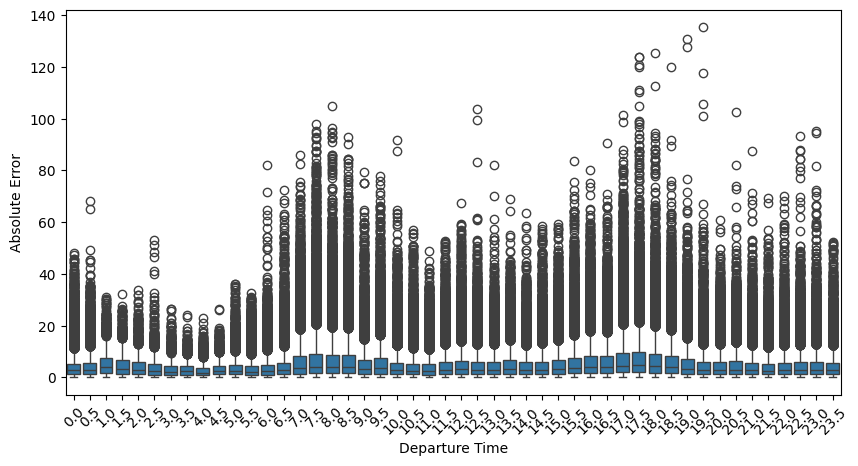

In [52]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(dpi=300)
fig, ax = plt.subplots(figsize=(10, 5))
sns.boxplot(data=results_df, x='FZ_AB', y='absolute error', ax=ax)
ax.tick_params(axis='x', rotation=45)
ax.set_xlabel('Departure Time')
ax.set_ylabel('Absolute Error')
plt.savefig('fzab_error_box.png')

<Figure size 1920x1440 with 0 Axes>

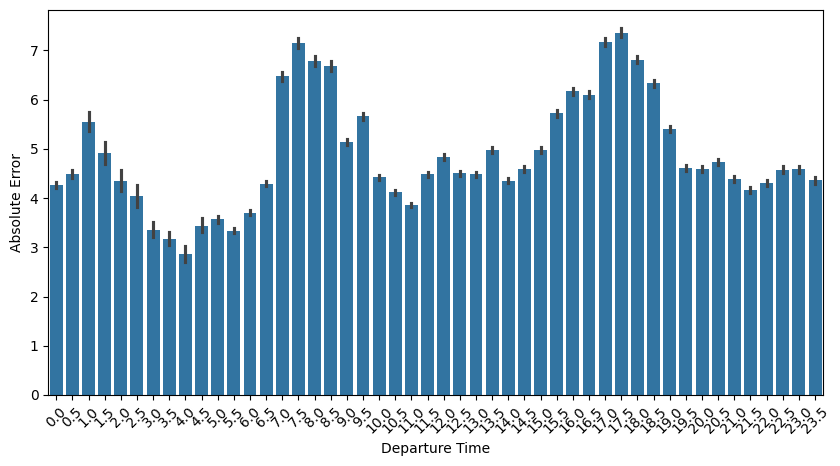

In [53]:
plt.figure(dpi=300)
fig, ax = plt.subplots(figsize=(10, 5))
sns.barplot(data=results_df, x='FZ_AB', y='absolute error', ax=ax)
ax.tick_params(axis='x', rotation=45)
ax.set_xlabel('Departure Time')
ax.set_ylabel('Absolute Error')
plt.savefig('fzab_error.png')

<Figure size 1920x1440 with 0 Axes>

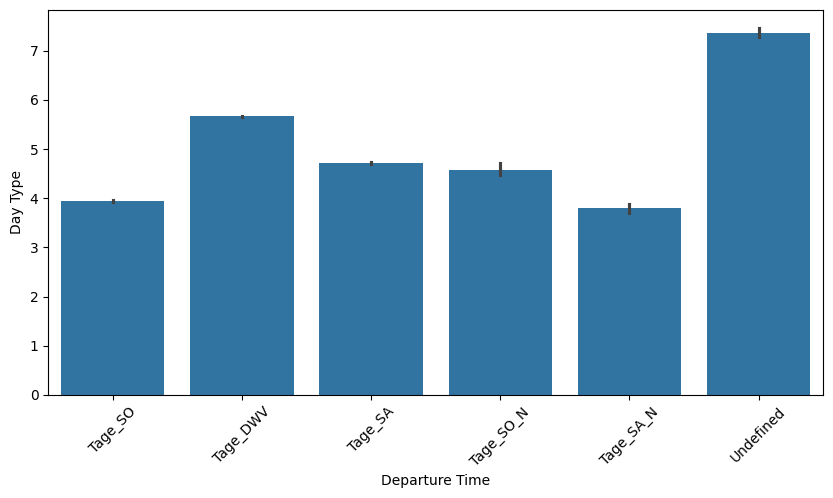

In [54]:
results_df['tagtype'] = "Undefined"
results_df.loc[results_df['Tage_DWV'] == 1.0, 'tagtype'] = "Tage_DWV"
results_df.loc[results_df['Tage_SA'] == 1.0, 'tagtype'] = "Tage_SA"
results_df.loc[results_df['Tage_SO'] == 1.0, 'tagtype'] = "Tage_SO"
results_df.loc[results_df['Tage_SA_N'] == 1.0, 'tagtype'] = "Tage_SA_N"
results_df.loc[results_df['Tage_SO_N'] == 1.0, 'tagtype'] = "Tage_SO_N"

plt.figure(dpi=300)
fig, ax = plt.subplots(figsize=(10, 5))
sns.barplot(data=results_df, x='tagtype', y='absolute error', ax=ax)
ax.tick_params(axis='x', rotation=45)
ax.set_xlabel('Departure Time')
ax.set_ylabel('Day Type')
plt.savefig('tagtype_error.png')

# Without Coordinates

in preliminary experiments, we found that adding coordiantes migth be helpful. Let's try what happens if we don't add them.

In [29]:
train_df_no_cords = train_df.drop(['GPS_Latitude_From', 'GPS_Latitude_To', 'GPS_Longitude_From', 'GPS_Longitude_To'], axis=1)
test_df_no_cords = test_df.drop(['GPS_Latitude_From', 'GPS_Latitude_To', 'GPS_Longitude_From', 'GPS_Longitude_To'], axis=1)

train_dataset_no_cords = VbzDataset(train_df_no_cords)
train_loader_no_cords = torch.utils.data.DataLoader(train_dataset_no_cords, batch_size=batch_size, shuffle=True, pin_memory=True)

test_set_no_cords = VbzDataset(test_df_no_cords)
test_loader_no_cords = torch.utils.data.DataLoader(test_set_no_cords, batch_size=batch_size, shuffle=False, pin_memory=True)

In [30]:
test_df_no_cords

,FZ_AB,Besetzung,Tage_DWV,Tage_SA,Tage_SO,Tage_SA_N,Tage_SO_N,Line_2,Line_3,Line_4,...,Line_743,Line_744,Line_745,Line_751,Line_753,Line_910,Line_912,Line_916,Line_918,Line_919
0,9.5,-1.197121,False,False,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,10.0,-1.124707,False,False,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,11.5,1.030208,True,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,11.5,0.976690,True,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,11.5,0.978305,True,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1139856,2.5,-1.187373,False,False,False,False,True,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1139857,3.0,-1.224973,False,False,False,False,True,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1139858,3.5,-1.209306,False,False,False,False,True,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1139859,4.0,-1.193640,False,False,False,False,True,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [31]:
train_df_no_cords

,FZ_AB,Besetzung,Tage_DWV,Tage_SA,Tage_SO,Tage_SA_N,Tage_SO_N,Line_2,Line_3,Line_4,...,Line_743,Line_744,Line_745,Line_751,Line_753,Line_910,Line_912,Line_916,Line_918,Line_919
0,21.0,-1.023188,True,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,21.5,-1.047230,True,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,21.5,-1.030447,True,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,22.0,-1.032653,True,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,22.0,-1.063832,True,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
972433,20.0,-1.036975,False,True,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
972434,21.0,-0.723645,False,True,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
972435,22.0,-1.115307,False,True,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
972436,23.0,-1.052641,False,True,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


## Create a new model, optimizer, and learning rate scheduler (same setting as before)

In [32]:
model_no_cords = VbzModel([109, 512, 512, 756, 756])
optimizer_no_cords = optim.Adam(model_no_cords.parameters(), lr=0.01)
lr_scheduler_no_cords = optim.lr_scheduler.ReduceLROnPlateau(optimizer_no_cords, mode='min', factor=0.1, patience=3)

## Train the Model without Coordinates

In [33]:
model_no_cords.to(device)

best_mae_no_cords = 100
train_loss_epochs_no_cords, test_loss_epochs_no_cords = [], []
train_mae_epochs_no_cords, test_mae_epochs_no_cords = [], []
train_mse_epochs_no_cords, test_mse_epochs_no_cords = [], []
for epoch in range(epochs):
    loss_sum, mae_sum, mse_sum = 0, 0, 0
    model_no_cords.train()
    for i, data in enumerate(train_loader_no_cords):
        inputs, targets = data
        inputs, targets = inputs.to(device), targets.to(device)
        
        optimizer_no_cords.zero_grad()
        outputs = model_no_cords(inputs)
        loss_val = loss(outputs, targets)
        loss_val.backward()
        # torch.nn.utils.clip_grad_norm_(model.parameters(), 0.1)
        optimizer_no_cords.step()
        
        loss_sum += loss_val.item() * inputs.size(0)
        mae, mse = calculate_statistics(outputs, targets)
        mae_sum += mae.item()
        mse_sum += mse.item()
        
    train_loss_epochs_no_cords.append(loss_sum / len(train_loader_no_cords.dataset))
    train_mae_epochs_no_cords.append(mae_sum / len(train_loader_no_cords.dataset))
    train_mse_epochs_no_cords.append(mse_sum / len(train_loader_no_cords.dataset))
    print(f'Training: Epoch: {epoch+1}, Loss: {train_loss_epochs_no_cords[-1]}, MAE: {train_mae_epochs_no_cords[-1]}, MSE: {train_mse_epochs_no_cords[-1]}')
    
    loss_sum, mae_sum, mse_sum = 0, 0, 0
    model_no_cords.eval()
    with torch.no_grad():
        for i, data in enumerate(test_loader_no_cords):
            inputs, targets = data
            inputs, targets = inputs.to(device), targets.to(device)
            
            outputs = model_no_cords(inputs)
            loss_val = loss(outputs, targets)
            loss_sum += loss_val.item() * inputs.size(0)
            mae, mse = calculate_statistics(outputs, targets)
            mae_sum += mae.item()
            mse_sum += mse.item()
    
    test_loss_epochs_no_cords.append(loss_sum / len(test_loader.dataset))
    test_mae_epochs_no_cords.append(mae_sum / len(test_loader.dataset))
    test_mse_epochs_no_cords.append(mse_sum / len(test_loader.dataset))
    print(f'Testing: Epoch: {epoch+1}, Loss: {test_loss_epochs_no_cords[-1]}, MAE: {test_mae_epochs_no_cords[-1]}, MSE: {test_mse_epochs_no_cords[-1]}')

    if test_mae_epochs_no_cords[-1] < best_mae_no_cords:
        torch.save({
                'epoch': epoch,
                'model_state_dict': model_no_cords.state_dict(),
                'optimizer_state_dict': optimizer_no_cords.state_dict(),
                'loss': loss,
            }, "checkpoint_no_cords.pth")
        best_mae = test_mae_epochs[-1]

    lr_scheduler_no_cords.step(test_loss_epochs[-1])

Training: Epoch: 1, Loss: 0.5970756592477457, MAE: 8.708590455031564, MSE: 152.0429418440599
Testing: Epoch: 1, Loss: 0.7955186811314637, MAE: 9.83687886639223, MSE: 202.57566794274976
Training: Epoch: 2, Loss: 0.5441275811284962, MAE: 8.37670790021498, MSE: 138.5599246554554
Testing: Epoch: 2, Loss: 0.7631338928543644, MAE: 9.819765942563139, MSE: 194.32901049837852
Training: Epoch: 3, Loss: 0.5413443541116698, MAE: 8.356319892064914, MSE: 137.8511865757759
Testing: Epoch: 3, Loss: 0.800952104362609, MAE: 9.79245498862203, MSE: 203.95926857784693
Training: Epoch: 4, Loss: 0.5393736423242388, MAE: 8.339809473689293, MSE: 137.3493529228385
Testing: Epoch: 4, Loss: 0.7923428890389005, MAE: 9.824016778956931, MSE: 201.76696578778012
Training: Epoch: 5, Loss: 0.5375844674613665, MAE: 8.326297661783784, MSE: 136.89374663806947
Testing: Epoch: 5, Loss: 0.7662734872435909, MAE: 9.723440760435842, MSE: 195.12849545447443
Training: Epoch: 6, Loss: 0.527634412789672, MAE: 8.227932845466135, MSE:

## Plot Training and Testing Metrics

We already see that the model without coordinates performs worse than the model with coordinates.

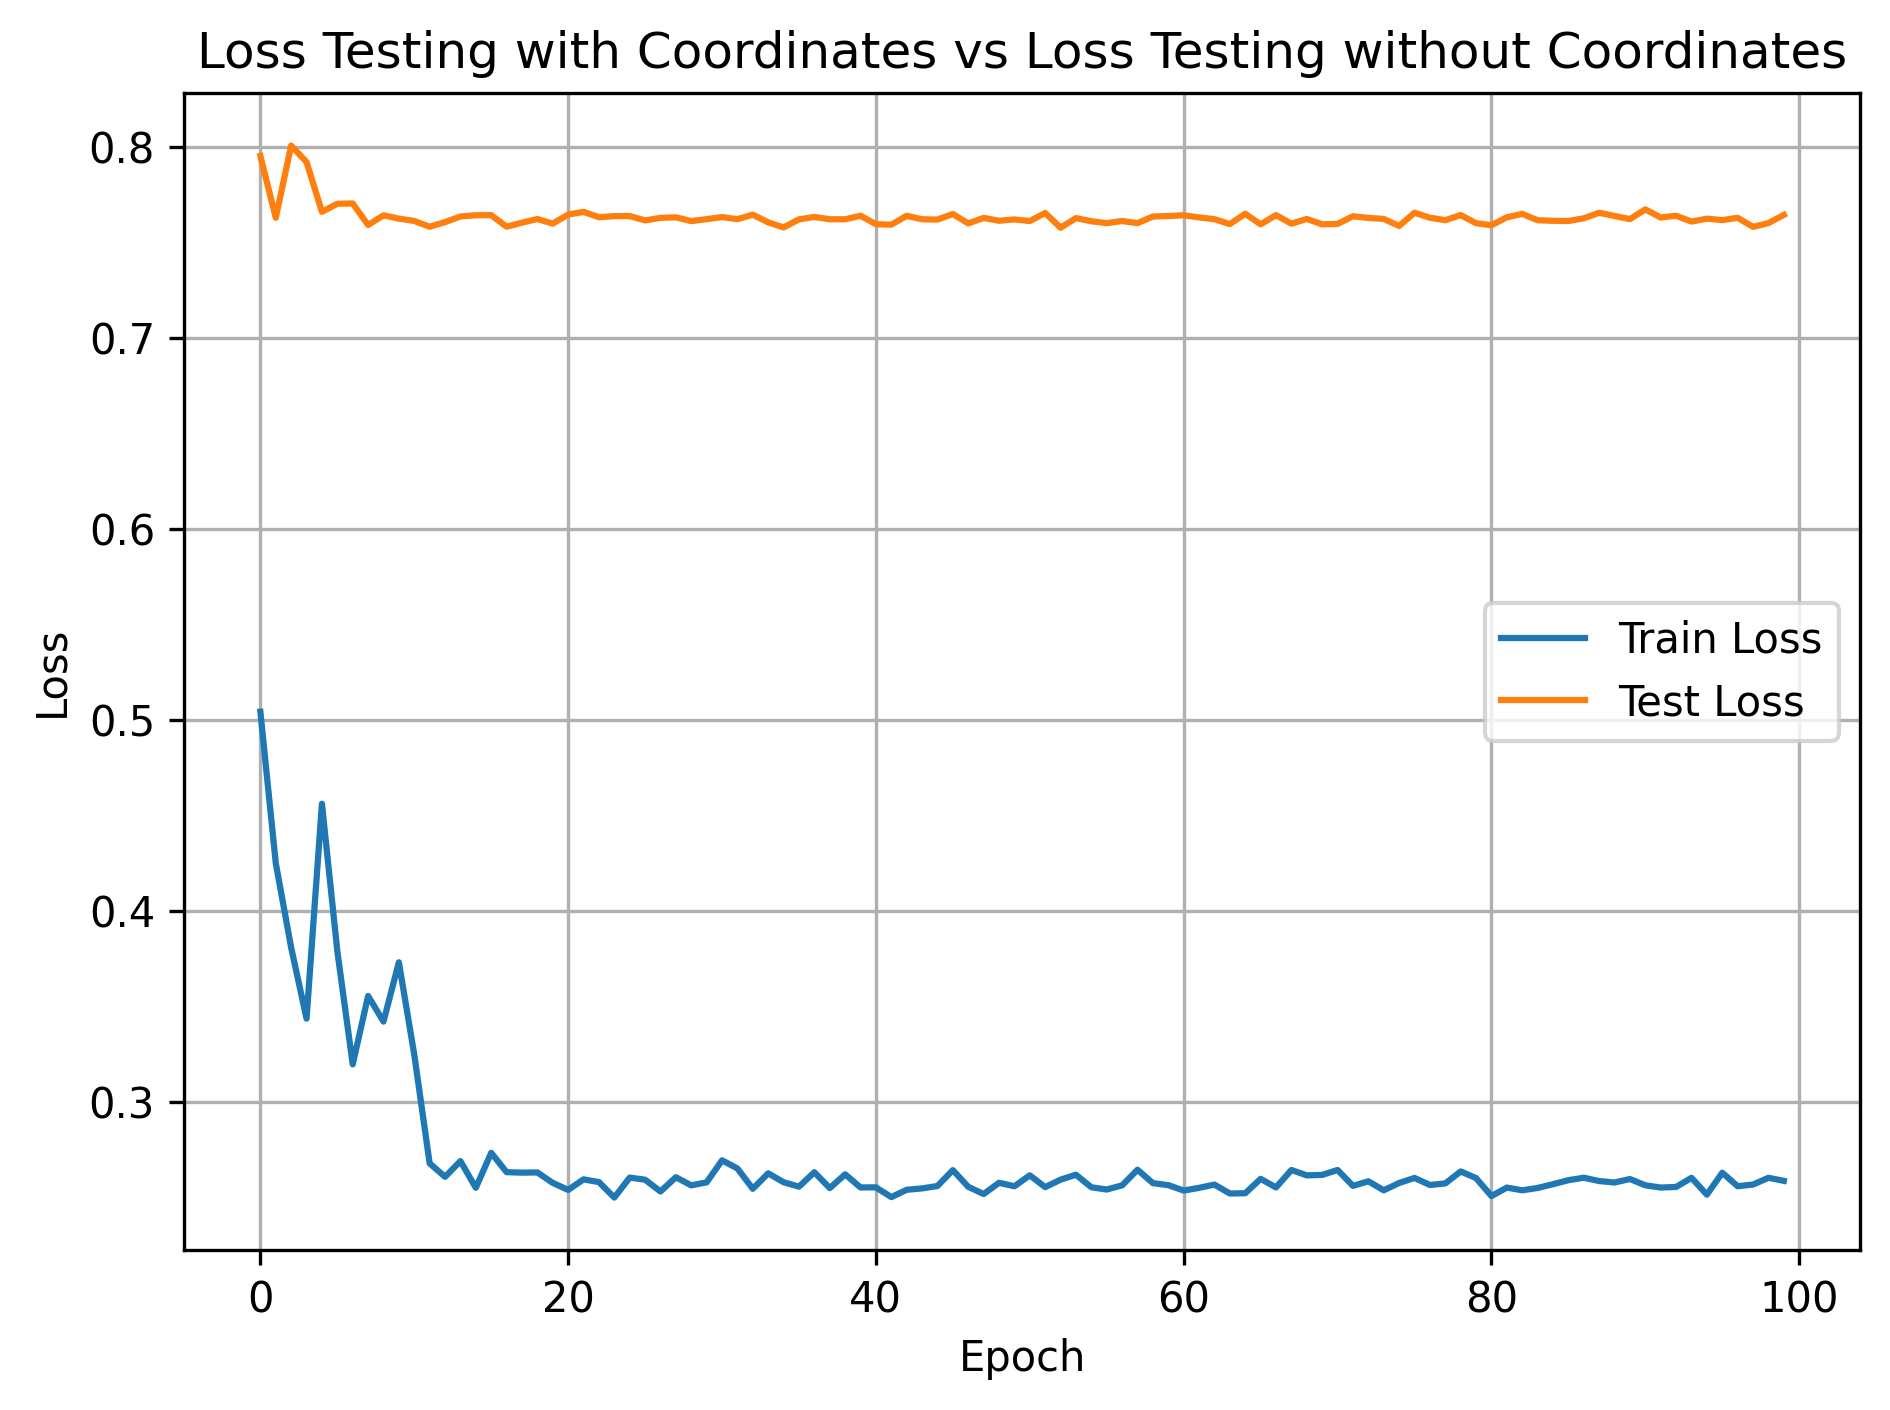

In [60]:
plot_metric(test_loss_epochs, test_loss_epochs_no_cords, 'Loss', 'Loss Testing with Coordinates vs Loss Testing without Coordinates', 'loss_epochs_without_coordinates.png')

## Load the Best Model without Coordinates and Evaluate on the Test Set

In [38]:
best_model_no_cords = VbzModel([109, 512, 512, 756, 756])
best_model_no_cords.load_state_dict(torch.load("checkpoint_no_cords.pth")["model_state_dict"])

best_model_no_cords.to(device)

test_loss_no_cords, test_mae_no_cords, test_mse_no_cords, all_inputs_no_cords, all_predictions_no_cords, all_targets_no_cords = evaluate_model(best_model_no_cords, test_loader_no_cords)
print(f'Test Loss without GPS Coordinates: {test_loss_no_cords}, Test MAE without GPS Coordinates: {test_mae_no_cords}, Test MSE without GPS Coordinates: {test_mse_no_cords}')

Test Loss without GPS Coordinates: 0.7646627604648192, Test MAE without GPS Coordinates: 9.683707923415659, Test MSE without GPS Coordinates: 194.7183303547246


## Plot Comparison of Predictions with and without Coordinates

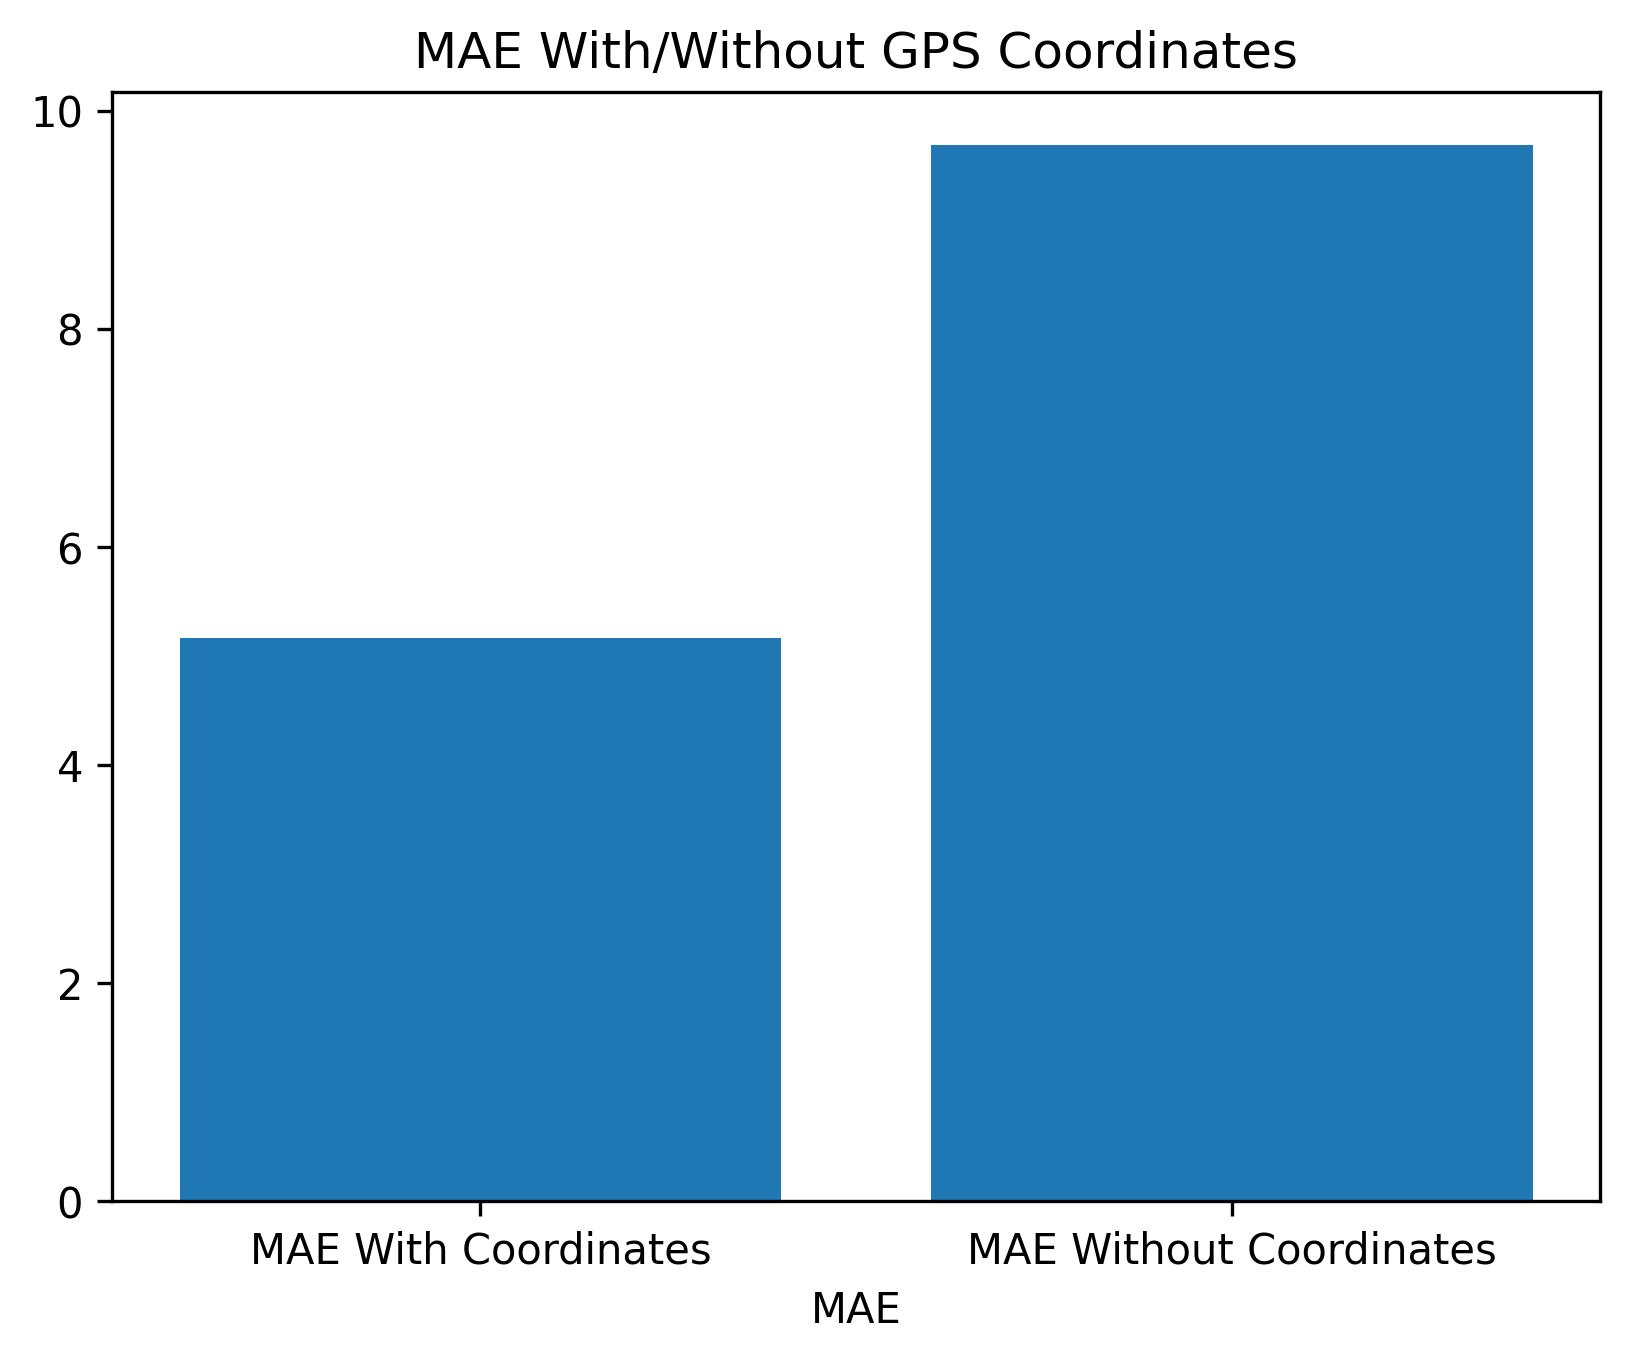

In [44]:
plt.figure(dpi=300)
labels = ['MAE With Coordinates', 'MAE Without Coordinates']
values = [test_mae, test_mae_no_cords]
plt.bar(labels, values)

plt.xlabel('MAE')
plt.title('MAE With/Without GPS Coordinates')
plt.savefig('mae_with-without_coordinates.png')
plt.show()
